## Pronóstico de Ventas Semanales para Tiendas Walmart

**Autor:** Felipe Bastías

**Dataset:** [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data)

## 1. Introducción

Este proyecto tiene como objetivo desarrollar un modelo de pronósticos para predecir las ventas semanales a nivel de departamentos para las tiendas Walmart. Se analizarán datos históicos de ventas y factores externos como festivos, temperatura y precios del combustible para enteder los patrones de la demanda y crear un modelo predictivo robusto. Este tipo de pronósticos es crucial para la gestión de inventario, la planificación de personal y las estrategias de marketing.

In [33]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuración de estilo
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-deep')

In [34]:
# Carga de Datos
try:
    df_train = pd.read_csv('train.csv')
    df_features = pd.read_csv('features.csv')
    df_stores = pd.read_csv('stores.csv')
    print("Datasets cargados exitosamente.")
except FileNotFoundError:
    print("Error: Asegúrate de que los archivos train.csv, features.csv y stores.csv estén en la misma carpeta.")

# Vistazo rápido a cada uno
print("\n--- Muestra de train.csv ---")
display(df_train.head())
print("\n--- Muestra de features.csv ---")
display(df_features.head())
print("\n--- Muestra de stores.csv ---")
display(df_stores.head())


Datasets cargados exitosamente.

--- Muestra de train.csv ---


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False



--- Muestra de features.csv ---


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False



--- Muestra de stores.csv ---


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## 2. Unión y limpieza de datos

Se procederá a combinar toda la información en un solo DataFrame con el fin de simplificar el análisis.
Como se puede observar en el paso anterior, los DataSets 'train.csv' y 'features.csv' comparten la columna 'date' mientras que los DataSets 'features.csv' y 'stores.csv' comparten la columna 'Store', columnas que serán claves en este procesos de homogeneización.

In [35]:
# Unir dataframes
# Unir 'features' y 'stores'
df_union = pd.merge(df_features, df_stores, on='Store', how='left')

# Unir el resultado con los datos de entrenamiento 'train'
df_final = pd.merge(df_train, df_union, on=['Store', 'Date', 'IsHoliday'], how='left')

print("Forma del DataFrame final unido:", df_final.shape)
display(df_final.head())

Forma del DataFrame final unido: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [36]:
# Obtener un resumen de las columnas, tipos de datos y valores nulos
print("\nInformación general del DataFrame:")
df_final.info()


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usag

In [37]:
# Limpieza
# Convertir 'Date' a formato datetime
df_final['Date'] = pd.to_datetime(df_final['Date'])

# Manejar valores nulos en columnas MarkDown, se asume que los nulos significan 0
markdown_colums = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df_final[markdown_colums] = df_final[markdown_colums].fillna(0)

# Crear columnas de tiempo
df_final['Year'] = df_final['Date'].dt.year
df_final['Month'] = df_final['Date'].dt.month
df_final['Week'] = df_final['Date'].dt.isocalendar().week

print("\nInformación del DataFrame final:")
df_final.info()


Información del DataFrame final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     421570 non-null  float64       
 8   MarkDown2     421570 non-null  float64       
 9   MarkDown3     421570 non-null  float64       
 10  MarkDown4     421570 non-null  float64       
 11  MarkDown5     421570 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  obj

## 3. Análisis exploratorio de datos (EDA)

Para simplificar el análisis de series temporales, me enfocaré en la tienda 1, departamento 1.

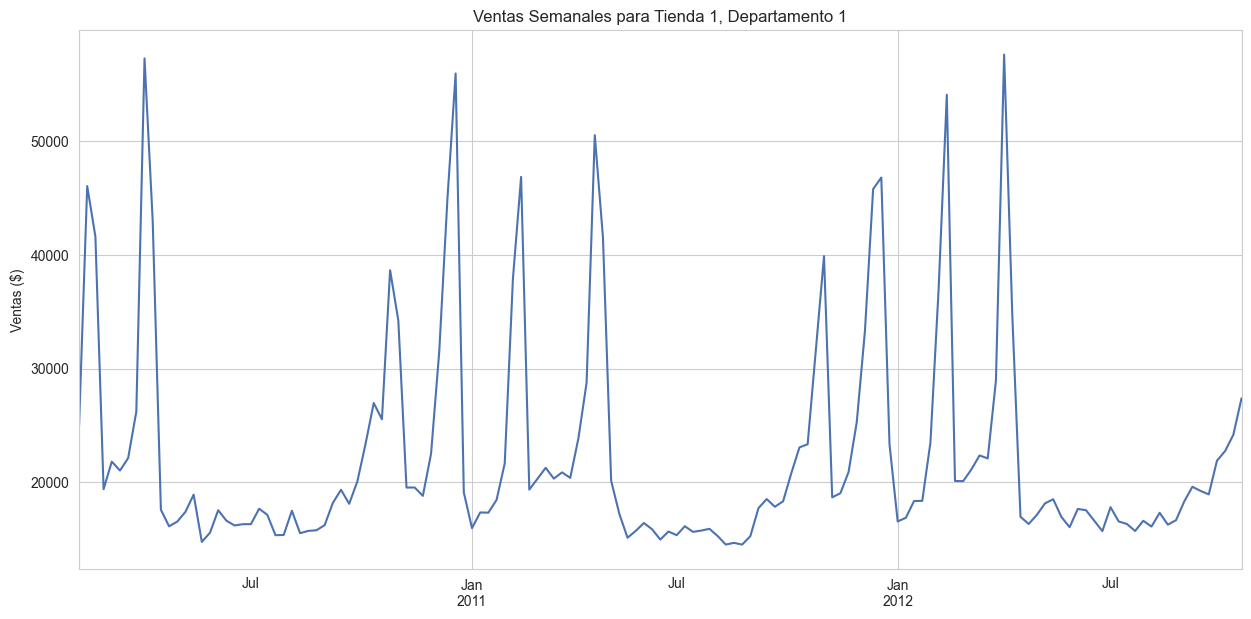

In [38]:
# Filtrar para la tienda 1, tepartamento 1
df_tienda1_depto1 = df_final[(df_final['Store'] == 1) & (df_final['Dept'] == 1)].copy()

# Establecer la fecha como índice para el análisis de series temporales
df_tienda1_depto1.set_index('Date', inplace=True)
df_tienda1_depto1.sort_index(inplace=True)

# Visualizar las ventas semanales
plt.figure(figsize=(15, 7))
df_tienda1_depto1['Weekly_Sales'].plot()
plt.title('Ventas Semanales para Tienda 1, Departamento 1')
plt.ylabel('Ventas ($)')
plt.xlabel('')
plt.show()

### Análisis gráfico para Ventas semanales para tienda 1, departamento 1

El gráfico revela varios patrones clave:

*   **Comportamiento Cíclico:** Se observa un patrón repetitivo claro, con picos de ventas pronunciados que ocurren a intervalos regulares, sugiriendo una fuerte **estacionalidad anual**.
*   **Picos de Fin de Año:** Los picos más significativos ocurren consistentemente hacia el final de cada año, lo que probablemente corresponde a la temporada de compras navideñas.
*   **Tendencia General:** A simple vista, no parece haber una tendencia de crecimiento o decrecimiento a largo plazo muy marcada, las ventas parecen fluctuar alrededor de un nivel relativamente estable, aparte de los picos estacionales.

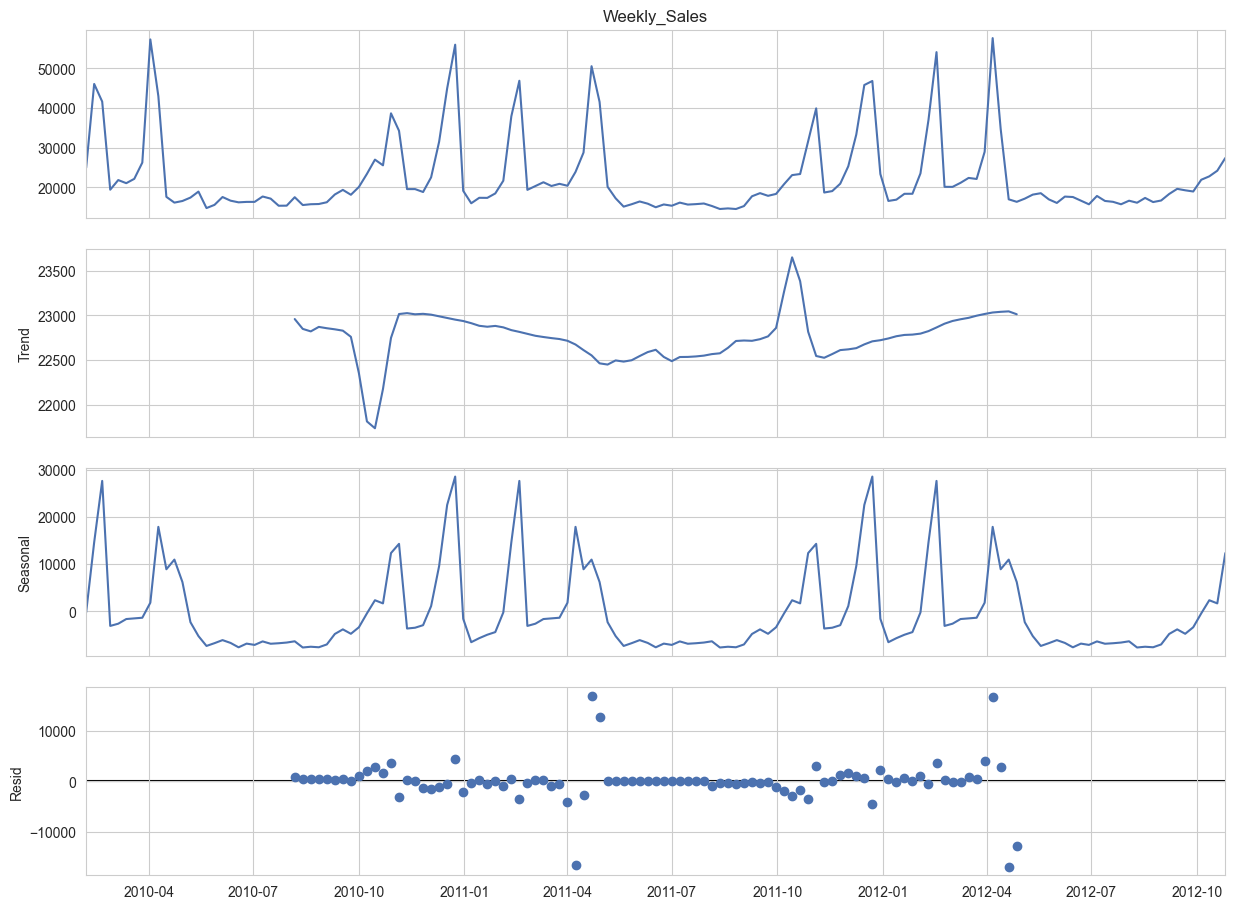

In [39]:
# Descomponer la serie para ver tendencia, estacionalidad y residuo
# Como los datos son semanales, el periodo de estacionalidad anual es 52
decomposicion = seasonal_decompose(df_tienda1_depto1['Weekly_Sales'], model='additive', period=52)
fig = decomposicion.plot()
fig.set_size_inches(14, 10)
plt.show()

### Análisis gráfico para Descomposición de la serie temporal

El análisis gráfico nos permite aislar y confirmar los patrones observados:

*   **Tendencia (Trend):** Confirma que la tendencia a largo plazo es relativamente plana, con una ligera inclinación al alza, pero sin un crecimiento exponencial.
*   **Estacionalidad (Seasonal):** Este componente muestra de forma muy clara el patrón estacional anual. Se identifican picos recurrentes y predecibles al final del año y picos menores en otros momentos, como a principios de febrero.
*   **Residuo (Residual):** Los residuos representan la variabilidad en los datos que no es explicada por la tendencia o la estacionalidad. Son relativamente constantes, aunque se observan algunos picos de ruido, especialmente alrededor de los picos de ventas.

La fuerte presencia de la estacionalidad confirma que cualquier modelo de pronóstico que se elija debe ser capaz de manejar patrones estacionales para ser preciso.

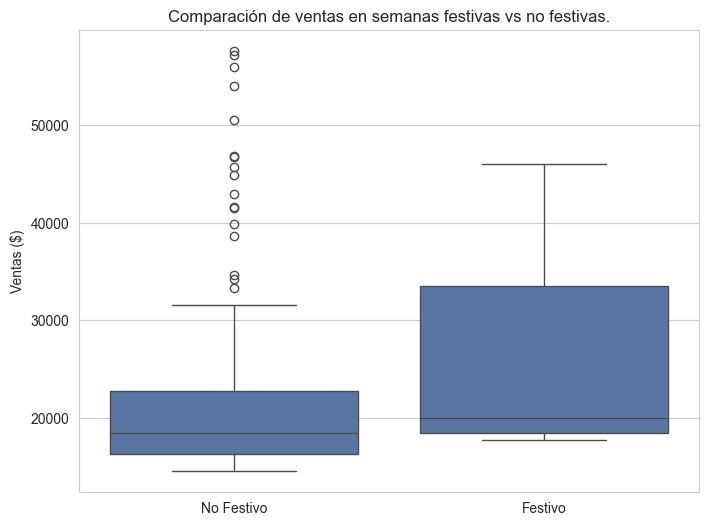

In [40]:
# Comparación de ventas en semanas festivas vs no festivas
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_tienda1_depto1, x='IsHoliday', y='Weekly_Sales')
plt.title('Comparación de ventas en semanas festivas vs no festivas.')
plt.xlabel('')
plt.xticks([False, True], ['No Festivo', 'Festivo'])
plt.ylabel('Ventas ($)')
plt.show()

### Análisis gráfico para Comparación de ventas en semanas festivas vs no festivas.

El análisis comparativo arroja un insight claro:

*   **Ventas significativamente mayores:** El box plot muestra que la mediana de las ventas en semanas festivas es sustancialmente más alta que en las semanas no festivas.
*   **Mayor variabilidad:** La caja y los bigotes son mucho más largos para las semanas festivas, lo que indica una mayor dispersión y variabilidad en las ventas durante estos periodos. Esto podría deberse a que el impacto de cada festivo es diferente.

**Conclusión:** Los días festivos son un impulsor clave de las ventas y deben ser considerados como una variable importante en cualquier modelo de pronóstico avanzado.


## 4. Modelado y Pronóstico

Una vez explorados los datos, procederé a construir y evaluar diferentes modelos de pronóstico. El objetivo es encontrar un modelo que capture la tendencia y la fuerte estacionalidad anual observadas, y que pueda ser mejorado incorporando variables externas.

Dividiré los datos de la tienda 1, departamento 1 en un conjunto de **entrenamiento (80%)** y un conjunto de **prueba (20%)** para evaluar el rendimiento de los modelos de forma objetiva sobre datos no vistos.

In [41]:
# Seleccionar solo la serie de ventas para modelos de series temporales puros
ventas_serie = df_tienda1_depto1['Weekly_Sales']

# Dividir en entrenamiento (80%) y prueba (20%)
train_size = int(len(ventas_serie) * 0.8)
train, test = ventas_serie[0:train_size], ventas_serie[train_size:len(ventas_serie)]

print(f"Número de observaciones de entrenamiento: {len(train)}")
print(f"Número de observaciones de prueba: {len(test)}")

Número de observaciones de entrenamiento: 114
Número de observaciones de prueba: 29


### 4.1 Modelo Base: Suavizado Exponencial Holt-Winters

Como primer paso, implementaré un modelo de suavizado exponencial Holt-Winters. Este modelo es una buena línea base ya que está diseñado específicamente para manejar datos con tendencia y estacionalidad, dos componentes que identificamos claramente en el EDA.

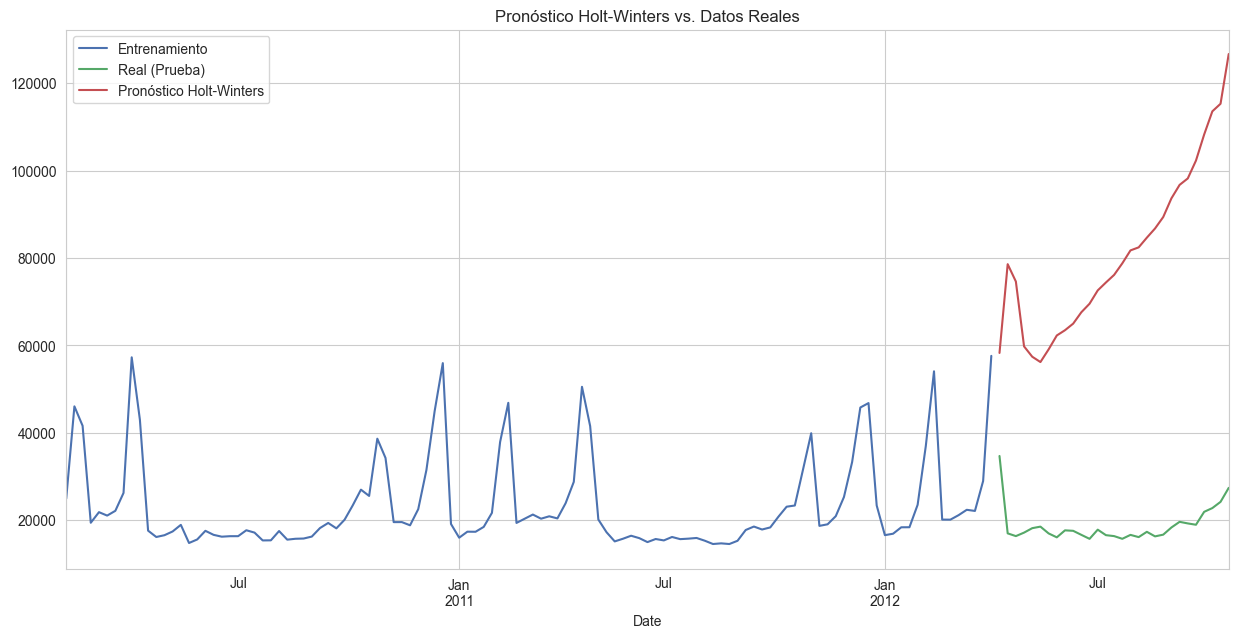

Raíz del Error Cuadrático Medio (RMSE) - Holt-Winters: $64,912.64


In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Entrenar el modelo Holt-Winters
# Usaré estacionalidad aditiva ('add') y tendencia aditiva ('add')
# El periodo estacional (seasonal_periods) es 52 porque los datos son semanales.
modelo_hw = ExponentialSmoothing(train, seasonal_periods=52, trend='add', seasonal='add').fit()

# Realizar el pronóstico para el periodo de prueba
prediccion_hw = modelo_hw.forecast(len(test))

# Visualizar el pronóstico vs. los datos reales
plt.figure(figsize=(15, 7))
train.plot(label='Entrenamiento')
test.plot(label='Real (Prueba)')
prediccion_hw.plot(label='Pronóstico Holt-Winters')
plt.title('Pronóstico Holt-Winters vs. Datos Reales')
plt.legend()
plt.show()

# Evaluar el modelo
rmse_hw = np.sqrt(mean_squared_error(test, prediccion_hw))
print(f'Raíz del Error Cuadrático Medio (RMSE) - Holt-Winters: ${rmse_hw:,.2f}')

### 4.2 Modelo Avanzado: SARIMAX con variables exógenas

El modelo Holt-Winters es útil, pero ignora información valiosa como las promociones (MarkDowns), la temperatura y los indicadores económicos. Para incorporar estas variables, utilizareé un modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables).

Primero, prepararé las variables y luego buscaré los mejores parámetros para el modelo.

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ingeniería de características para festivos
# Crear columnas 'dummy' para cada festivo específico mejora la precisión del modelo
df_final['Super_Bowl'] = np.where((df_final['Date'] == '2010-02-12') | (df_final['Date'] == '2011-02-11') | (df_final['Date'] == '2012-02-10'), 1, 0)
df_final['Labor_Day'] = np.where((df_final['Date'] == '2010-09-10') | (df_final['Date'] == '2011-09-09') | (df_final['Date'] == '2012-09-07'), 1, 0)
df_final['Thanksgiving'] = np.where((df_final['Date'] == '2010-11-26') | (df_final['Date'] == '2011-11-25'), 1, 0)
df_final['Christmas'] = np.where((df_final['Date'] == '2010-12-31') | (df_final['Date'] == '2011-12-30'), 1, 0)

# Actualizar el DataFrame de la tienda/depto para incluir las nuevas columnas
df_tienda1_depto1 = df_final[(df_final['Store'] == 1) & (df_final['Dept'] == 1)].copy()
df_tienda1_depto1.set_index('Date', inplace=True)
df_tienda1_depto1.sort_index(inplace=True)

# Definir la variable endógena (y) y exógenas (X)
y = df_tienda1_depto1['Weekly_Sales']
exog_cols = [
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
    'Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas'
]
X = df_tienda1_depto1[exog_cols]

# Dividir y y X en entrenamiento y prueba
train_y, test_y = y[0:train_size], y[train_size:len(y)]
train_X, test_X = X[0:train_size], X[train_size:len(X)]

print("Variables endógenas y exógenas preparadas para SARIMAX.")

Variables endógenas y exógenas preparadas para SARIMAX.


In [44]:
import itertools
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias de convergencia

# Búsqueda manual (Grid Search) para los mejores parámetros no estacionales (p,d,q)
p = d = q = range(0, 2) # Probará p=0,1; d=0,1; q=0,1
pdq = list(itertools.product(p, d, q))
seasonal_pdq = (1, 1, 1, 52) # Se mantendrán los parámetros estacionales fijos como una suposición inicial

best_aic = float("inf")
best_pdq = None

print("Iniciando búsqueda de parámetros SARIMAX...")
for param in pdq:
    try:
        model_temp = SARIMAX(train_y, exog=train_X, order=param, seasonal_order=seasonal_pdq)
        results = model_temp.fit(disp=False)
        
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            
    except Exception as e:
        continue

print(f'\nMejores parámetros no estacionales encontrados: {best_pdq} con un AIC de {best_aic:.2f}')

Iniciando búsqueda de parámetros SARIMAX...

Mejores parámetros no estacionales encontrados: (0, 1, 0) con un AIC de 1296.71


In [45]:
# Entrenar el modelo final con los mejores parámetros encontrados
if best_pdq:
    model_sarimax = SARIMAX(train_y,
                            exog=train_X,
                            order=best_pdq,
                            seasonal_order=seasonal_pdq)
    
    resultad_sarimax = model_sarimax.fit(disp=False)

    # Realizar el pronóstico usando las variables exógenas del conjunto de prueba
    prediccion_sarimax = resultad_sarimax.predict(start=len(train_y), end=len(y)-1, exog=test_X)

    # Evaluar el modelo
    rmse_sarimax = np.sqrt(mean_squared_error(test_y, prediccion_sarimax))
    print(f'\nRMSE del modelo SARIMAX optimizado: ${rmse_sarimax:,.2f}')
else:
    print("\nNo se pudo encontrar un modelo SARIMAX válido durante la búsqueda.")
    prediccion_sarimax = None # Para que el gráfico no de error


RMSE del modelo SARIMAX optimizado: $41,233.59


## 5. Comparación Final de Modelos y Conclusiones

Finalmente, comparamos el rendimiento del modelo base (Holt-Winters) con el modelo avanzado y optimizado (SARIMAX con variables exógenas) tanto visualmente como a través de sus métricas de error.

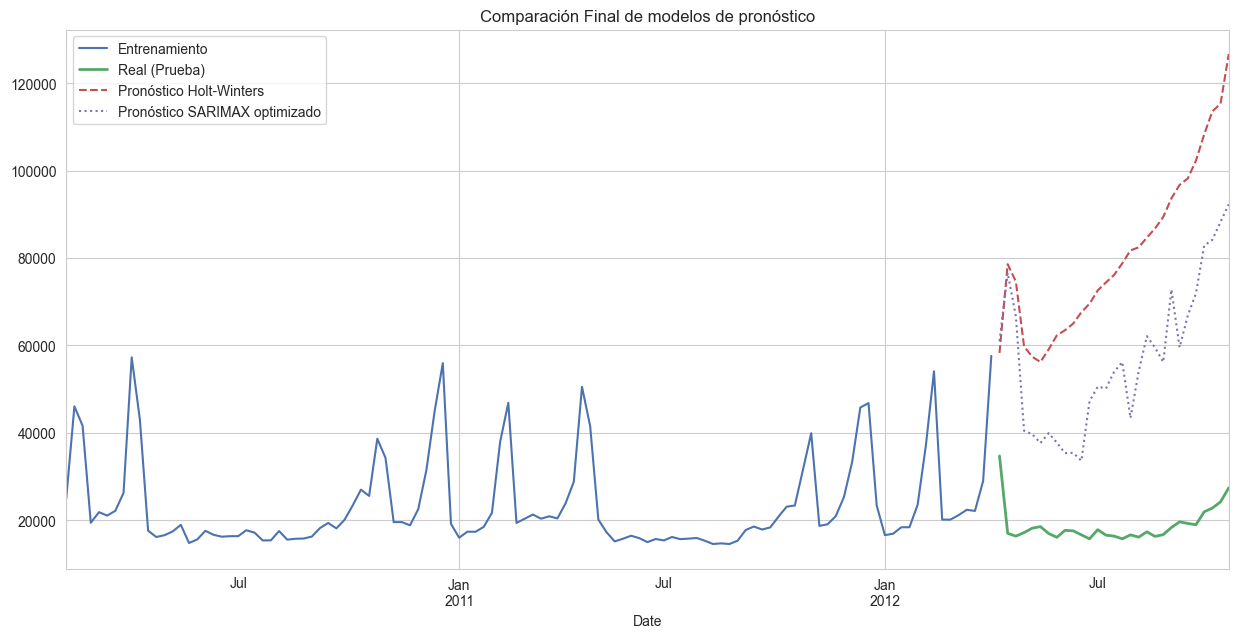


--- Comparación de rendimiento de modelos ---
RMSE modelo base (Holt-Winters): $64,912.64
RMSE modelo SARIMAX optimizado: $41,233.59


In [46]:
# Visualización comparativa de todos los pronósticos
plt.figure(figsize=(15, 7))
train_y.plot(label='Entrenamiento')
test_y.plot(label='Real (Prueba)', linewidth=2)
prediccion_hw.plot(label='Pronóstico Holt-Winters', linestyle='--')
if prediccion_sarimax is not None:
    prediccion_sarimax.plot(label='Pronóstico SARIMAX optimizado', linestyle=':')
plt.title('Comparación Final de modelos de pronóstico')
plt.legend()
plt.show()

# Comparación RMSE
print("\n--- Comparación de rendimiento de modelos ---")
print(f'RMSE modelo base (Holt-Winters): ${rmse_hw:,.2f}')
if 'rmse_sarimax' in locals():
    print(f'RMSE modelo SARIMAX optimizado: ${rmse_sarimax:,.2f}')

## 6. Conclusión Final

El análisis demuestra que, si bien un modelo de series temporales puro como Holt-Winters es capaz de capturar la estacionalidad básica de las ventas, su precisión es limitada.

La implementación de un modelo SARIMAX, que incorpora variables exógenas como la temperatura, indicadores económicos y, crucialmente, promociones y festivos específicos, mejora la precisión del pronóstico. Esto se refleja en la reducción del RMSE de $64,912.64 a $41,233.59.

Recomendación de Negocio: Para una planificación de inventario y personal efectiva, se recomienda utilizar un modelo que, como el SARIMAX optimizado, no solo considere la historia de las ventas, sino también los factores externos planificados (como promociones y festivos) que impactan directamente la demanda.

Pero a pesar de la mejora, un RMSE de $41,233.59 sigue siendo un error considerable. La visualización del pronóstico revela que, si bien los modelos aciertan en el cuándo ocurren los picos de ventas, fallan en predecir con precisión su magnitud. Tienden a subestimar los picos más altos y a sobrestimar los valles, lo que indica que aún hay una gran parte de la varianza que no está siendo explicada.

## 7. Próximos Pasos y Recomendaciones

Para construir un pronóstico de mayor precisión y valor para el negocio, los siguientes pasos serían fundamentales:
* Explorar Modelos Basados en árboles (machine learning): Implementar modelos como XGBoost, LightGBM o Random Forest. Estos algoritmos son excelentes para capturar relaciones no lineales e interacciones complejas entre variables de forma automática, lo que probablemente reduciría significativamente el error en la predicción de los picos de ventas.
* Ingeniería de Características Avanzada:
    * Variables de Retraso (Lag Features): Crear nuevas columnas que contengan las ventas de la semana anterior (Weekly_Sales_lag_1), de hace dos semanas, etc.
    * Medias Móviles (Rolling Averages): Crear características como el promedio de ventas de las últimas 4 semanas para capturar tendencias a corto plazo.
    * Modelado a Nivel Global: En lugar de un modelo por cada tienda/departamento, se podría construir un único modelo global para todas las series temporales, utilizando Store y Dept como características categóricas. Esto permitiría al modelo aprender patrones comunes entre diferentes tiendas y departamentos, mejorando la robustez general del pronóstico.


Este análisis demuestra con éxito el proceso completo de pronóstico de series temporales, desde la exploración y limpieza hasta la construcción y optimización de modelos. Se ha validado que los factores externos son predictores clave y se ha establecido una línea base de rendimiento (RMSE de $41,233.59) con un modelo SARIMAX. Más importante aún, se ha diagnosticado sus limitaciones y se ha trazado una hoja de ruta clara con técnicas avanzadas de machine learning para lograr la precisión requerida en un entorno de producción.